# Financial EDA & Forecasting System


### This notebook analyzes U.S. macroeconomic data, specifically the Consumer Price Index (CPI), and forecasts future CPI values using an ARIMA time series model.

Data Source: [FRED CPI Data](https://fred.stlouisfed.org/series/CPIAUCSL)

## Step 1: Install Required Packages

👩‍💻 Option A — If you're using Jupyter Notebook / Colab:

In [5]:
# Install dependencies using shell commands inside the notebook
!pip install numpy==1.26.4 pandas==2.2.2 --force-reinstall --no-cache-dir
!pip install pmdarima
!pip install pandas_datareader
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 1.3 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 2.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2025.2
    Uninstalling tzdata-2025.2:
      Successfully uninstalled tzdata-2025.2
  Attempting uninstall: six
    Found existing installation: six 1.17.0
    Uninstalling six-1.17.0:
      Successfully uninstalled six-1.17.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.9.0.post0
    Uninstalling python-dateutil-2.9.0.post0:
      Successfully uninstalled python-dateutil-2.9.0.post0
  Attempting uninstall:

🖥️ Option B — If you're using VS Code or Terminal:


## Step 2: Import Required Libraries



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import pandas_datareader.data as web
from pmdarima import auto_arima
import warnings
import sys
import os

## Step 3: User Inputs for Date Range

In [2]:
# Ask user for date range
# Step 3: Input and parse correctly
start_date = pd.to_datetime(input("Enter start date (DD-MM-YYYY): "), dayfirst=True)
end_date = pd.to_datetime(input("Enter end date (DD-MM-YYYY): "), dayfirst=True)

# Step 4: Use parsed datetime objects
df = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)

Enter start date (DD-MM-YYYY): 01-01-2000
Enter end date (DD-MM-YYYY): 30-12-2024


## Step 4: Load U.S. CPI Data from FRED

In [3]:
# Load CPI data from the Federal Reserve Economic Database
df = web.DataReader('CPIAUCSL', 'fred', start_date, end_date)
df.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True)
df.index = pd.to_datetime(df.index)

## Step 5: Calculate Year-over-Year (YoY) & Quarter-over-Quarter (QoQ)  Inflation

In [4]:
df['YoY_Inflation'] = df['CPI'].pct_change(periods=12) * 100
df['QoQ_Inflation'] = df['CPI'].pct_change(periods=3) * 100

## Step 6: Fit ARIMA Model to the CPI Data (silently)

In [5]:
def fit_arima_silently(series):
    with open(os.devnull, 'w') as f, warnings.catch_warnings():
        warnings.simplefilter("ignore")
        sys.stdout = f
        model = auto_arima(series,
                           seasonal=False,
                           stepwise=True,
                           suppress_warnings=True,
                           trace=False)
        sys.stdout = sys.__stdout__
    return model

model = fit_arima_silently(df['CPI'])

## Step 7: Forecast Future CPI Values

In [ ]:
# Ask how many months to forecast
forecast_period = int(input("Enter forecast period in months: "))

# Forecast with Confidence Intervals
forecast, conf_int = model.predict(n_periods=forecast_period, return_conf_int=True)

# Generate future dates for forecast
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1),
                               periods=forecast_period, freq='MS')

# Create Series with forecast values
forecast_series = pd.Series(forecast, index=forecast_index)

# Convert confidence intervals to DataFrame
conf_df = pd.DataFrame(conf_int, columns=['Lower CI', 'Upper CI'], index=forecast_index)

## Optional: Residuals Diagnostics to Verify Model Fit

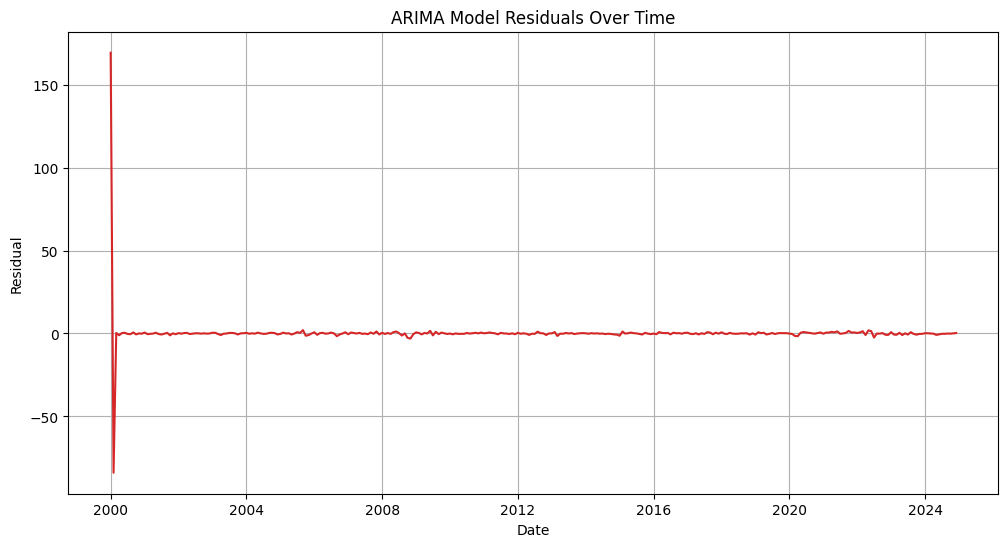

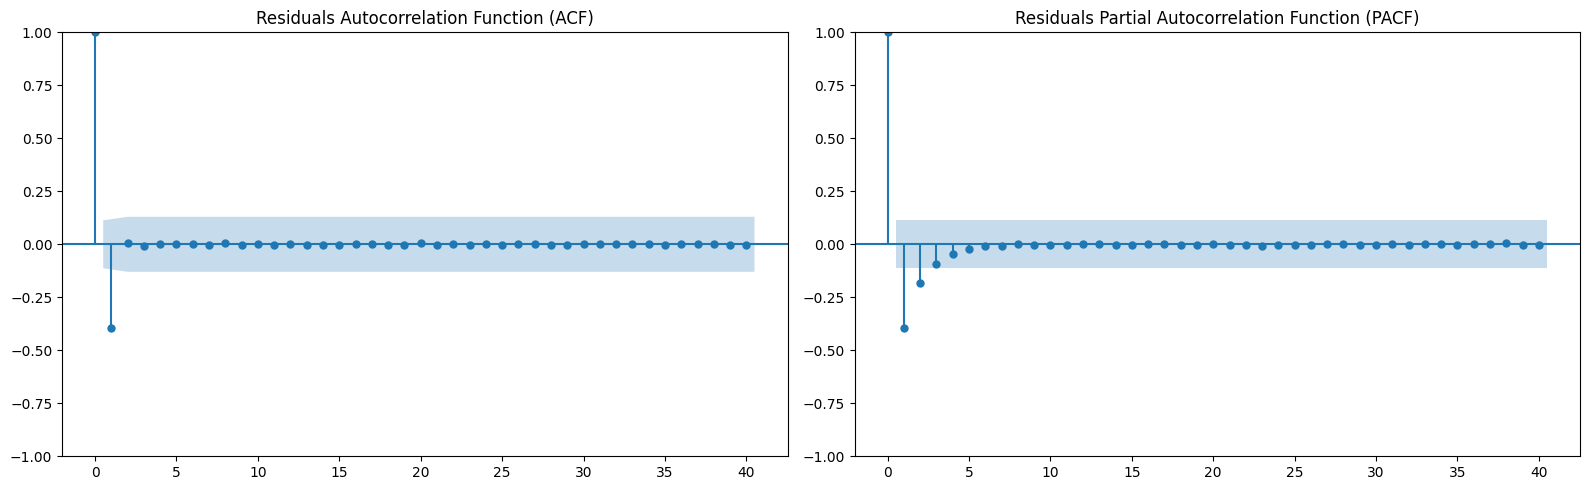

In [12]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox

# Calculate residuals: actual - fitted
residuals = pd.Series(model.resid(), index=df.index)

# Plot residuals over time
plt.figure(figsize=(12, 6))
plt.plot(residuals, color='tab:red')
plt.title('ARIMA Model Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid(True)
plt.show()

# Plot ACF and PACF of residuals
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ACF plot
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axes[0])
axes[0].set_title('Residuals Autocorrelation Function (ACF)')

# PACF plot
sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=axes[1])
axes[1].set_title('Residuals Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


## Step 8: Visualize YoY Inflation, QoQ Inflation, and Forecasted CPI

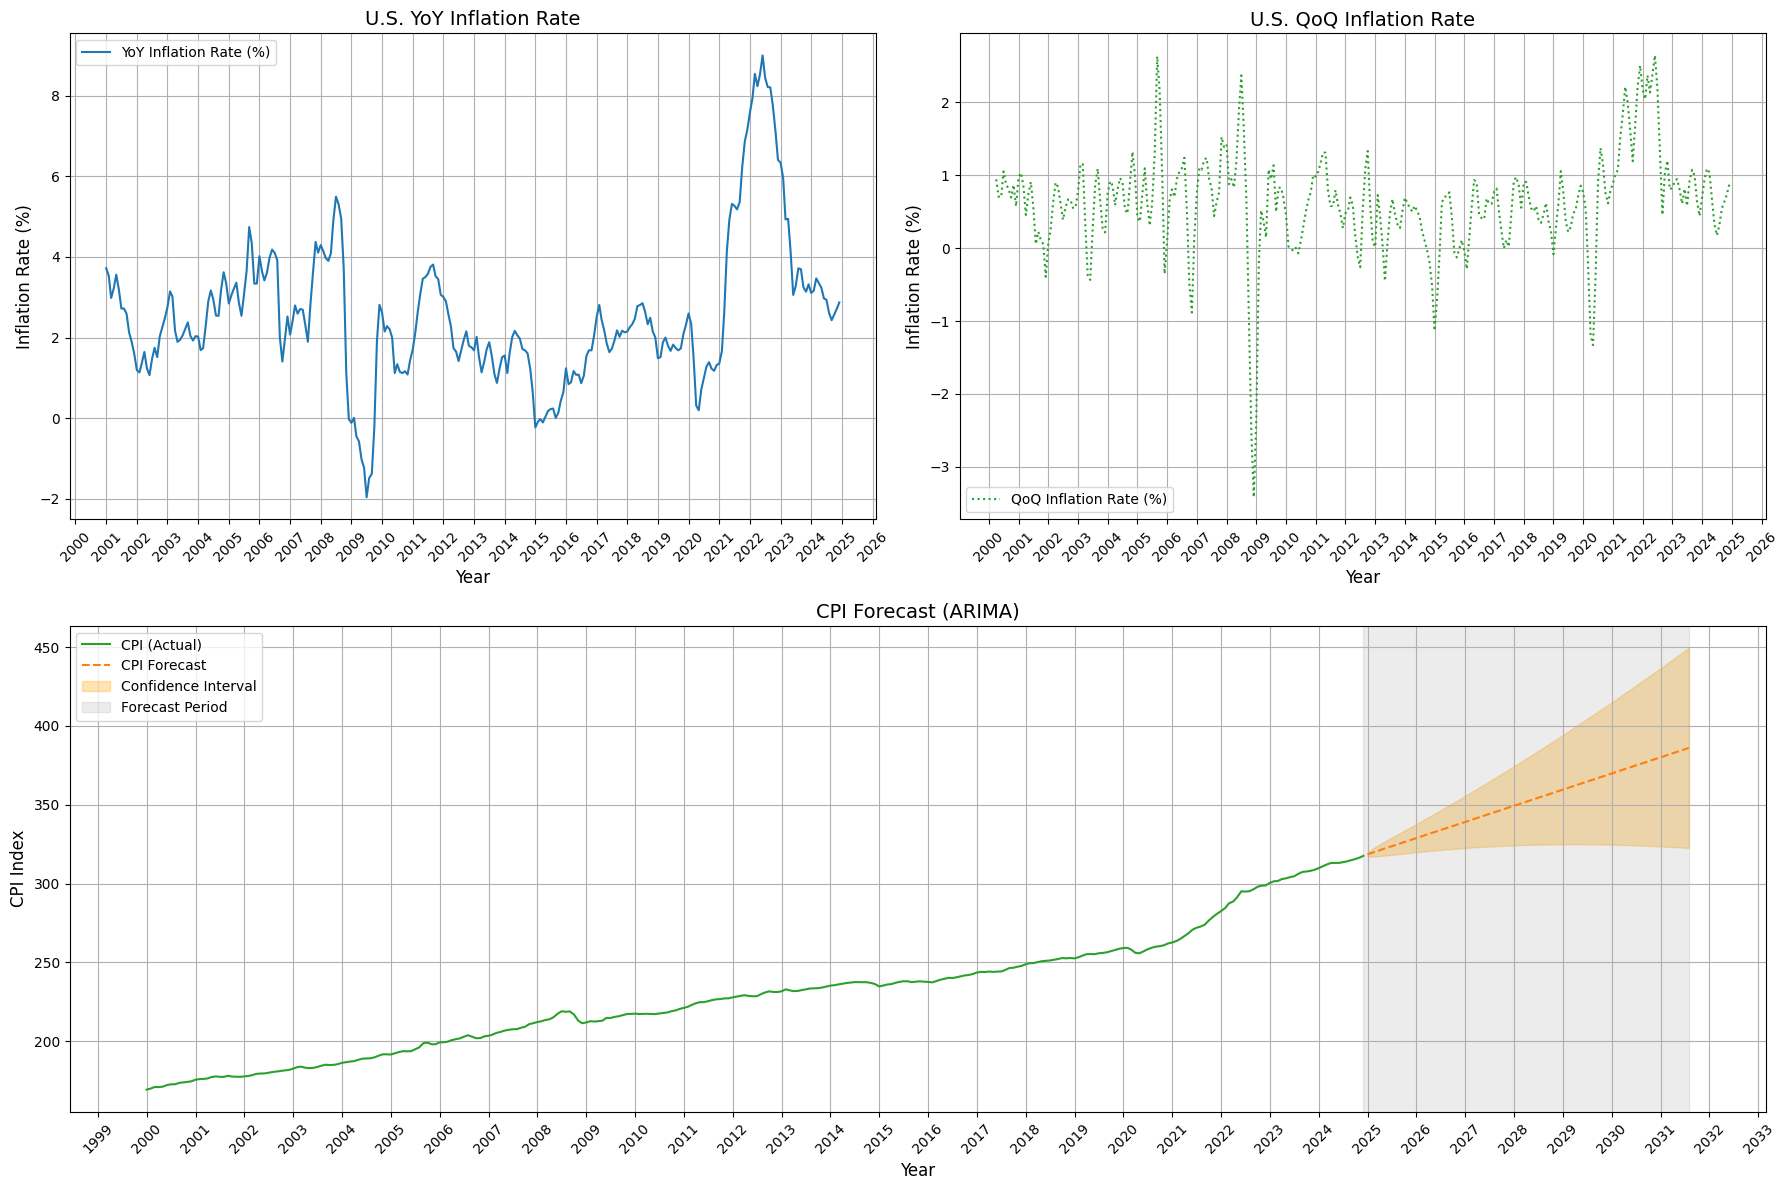

In [13]:
# === Combined Plot with YoY and QoQ on top, CPI Forecast below ===
fig = plt.figure(figsize=(18, 12))

# Top-left: YoY Inflation
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(df.index, df['YoY_Inflation'], color='tab:blue', label='YoY Inflation Rate (%)')
ax1.set_title('U.S. YoY Inflation Rate', fontsize=14)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Inflation Rate (%)', fontsize=12)
ax1.grid(True)
ax1.legend()
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.tick_params(axis='x', rotation=45)

# Top-right: QoQ Inflation
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(df.index, df['QoQ_Inflation'], label='QoQ Inflation Rate (%)', color='tab:green', linestyle=':')
ax2.set_title('U.S. QoQ Inflation Rate', fontsize=14)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Inflation Rate (%)', fontsize=12)
ax2.grid(True)
ax2.legend()
ax2.xaxis.set_major_locator(mdates.YearLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.tick_params(axis='x', rotation=45)

# Bottom (spanning full width): CPI Forecast
ax3 = fig.add_subplot(2, 1, 2)  # spans both columns since 2 rows, 1 col here
ax3.plot(df.index, df['CPI'], label='CPI (Actual)', color='tab:green')
ax3.plot(forecast_series.index, forecast_series, label='CPI Forecast', color='tab:orange', linestyle='--')

# Add confidence interval shading
ax3.fill_between(conf_df.index, conf_df['Lower CI'], conf_df['Upper CI'], color='orange', alpha=0.3, label='Confidence Interval')

ax3.axvspan(df.index[-1], forecast_series.index[-1], color='gray', alpha=0.15, label="Forecast Period")

ax3.set_title('CPI Forecast (ARIMA)', fontsize=14)
ax3.set_xlabel('Year', fontsize=12)
ax3.set_ylabel('CPI Index', fontsize=12)
ax3.grid(True)
ax3.legend()
ax3.xaxis.set_major_locator(mdates.YearLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax3.tick_params(axis='x', rotation=45)

# Adjust whitespace between plots
fig.subplots_adjust(wspace=0.3, hspace=0.4)

plt.tight_layout()
plt.show()